# **PROJECT_Group5: Predictive Analysis of Bank Marketing**

## Objective: To predict if a client will subscribe a term deposit.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate, GridSearchCV
from scipy import interp

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *

# STEP 1. Data Exploration & Data Cleaning

In [2]:
bank_df = pd.read_csv('../data/bank-additional-full.csv', sep=';')
display(bank_df.sample(5))
print(bank_df.shape)

age          job  marital          education default housing loan  \
24196   39       admin.  married  university.degree      no     yes   no   
18678   33   technician   single  university.degree      no      no   no   
13431   58      retired  married           basic.4y      no      no   no   
32854   30  blue-collar  married           basic.9y      no     yes   no   
40228   64       admin.  married        high.school      no      no   no   

        contact month day_of_week  ...  campaign  pdays  previous  \
24196  cellular   nov         mon  ...         1    999         1   
18678  cellular   jul         thu  ...         5    999         0   
13431  cellular   jul         wed  ...         1    999         0   
32854  cellular   may         mon  ...         5    999         0   
40228  cellular   jul         thu  ...         1    999         0   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
24196      failure         -0.1          93.200          -42.0      4.191   
18678  nonexistent          1.4          93.918          -42.7      4.968   
13431  nonexistent          1.4          93.918          -42.7      4.962   
32854  nonexistent         -1.8          92.893          -46.2      1.299   
40228  nonexistent         -1.7          94.215          -40.3      0.884   

       nr.employed    y  
24196       5195.8   no  
18678       5228.1   no  
13431       5228.1  yes  
32854       5099.1   no  
40228       4991.6  yes  

[5 rows x 21 columns]

(41188, 21)


<!-- Input variables:

1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no')
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no') -->

In [3]:
display(bank_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

None

In [4]:
np.count_nonzero(bank_df.isnull())

0

## Explore Numerical Variables

In [5]:
bank_df.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

### 'pdays' has missing values encoded as '999'

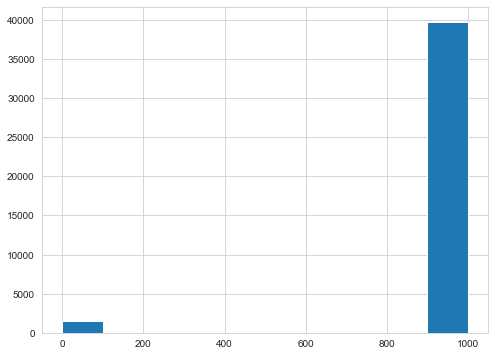

In [6]:
sns.set_style('whitegrid')
plt.subplots(figsize=(8, 6))
plt.hist(bank_df['pdays'])
plt.show()

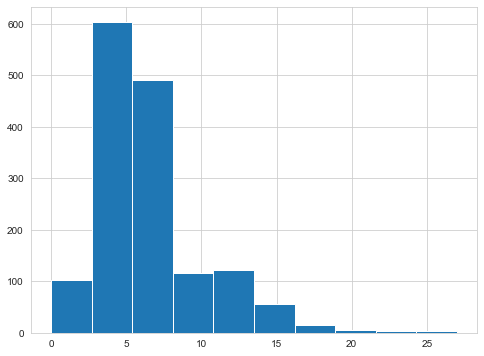

In [7]:
plt.subplots(figsize=(8, 6))
plt.hist(bank_df.loc[bank_df.pdays!=999, 'pdays'])
plt.show()

### *Option: Replace 999 with -1

In [8]:
# bank_df.loc[bank_df.pdays==999, 'pdays'] = -1

# plt.subplots(figsize=(8, 6))
# plt.hist(bank_df['pdays'])
# plt.show()

# display(bank_df['pdays'].describe())

### Since the result shows the higher prediction accuracy with no replacement, we will keep the data as it is.

In [3]:
bank_df['Target'] = LabelEncoder().fit_transform(bank_df['y'])
bank_df.drop('y', axis=1, inplace=True)

numeric = bank_df.select_dtypes(exclude="object")
numeric.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'Target'],
      dtype='object')

Text(0.5, 1.03, 'Pairplot for Numerical Variables')

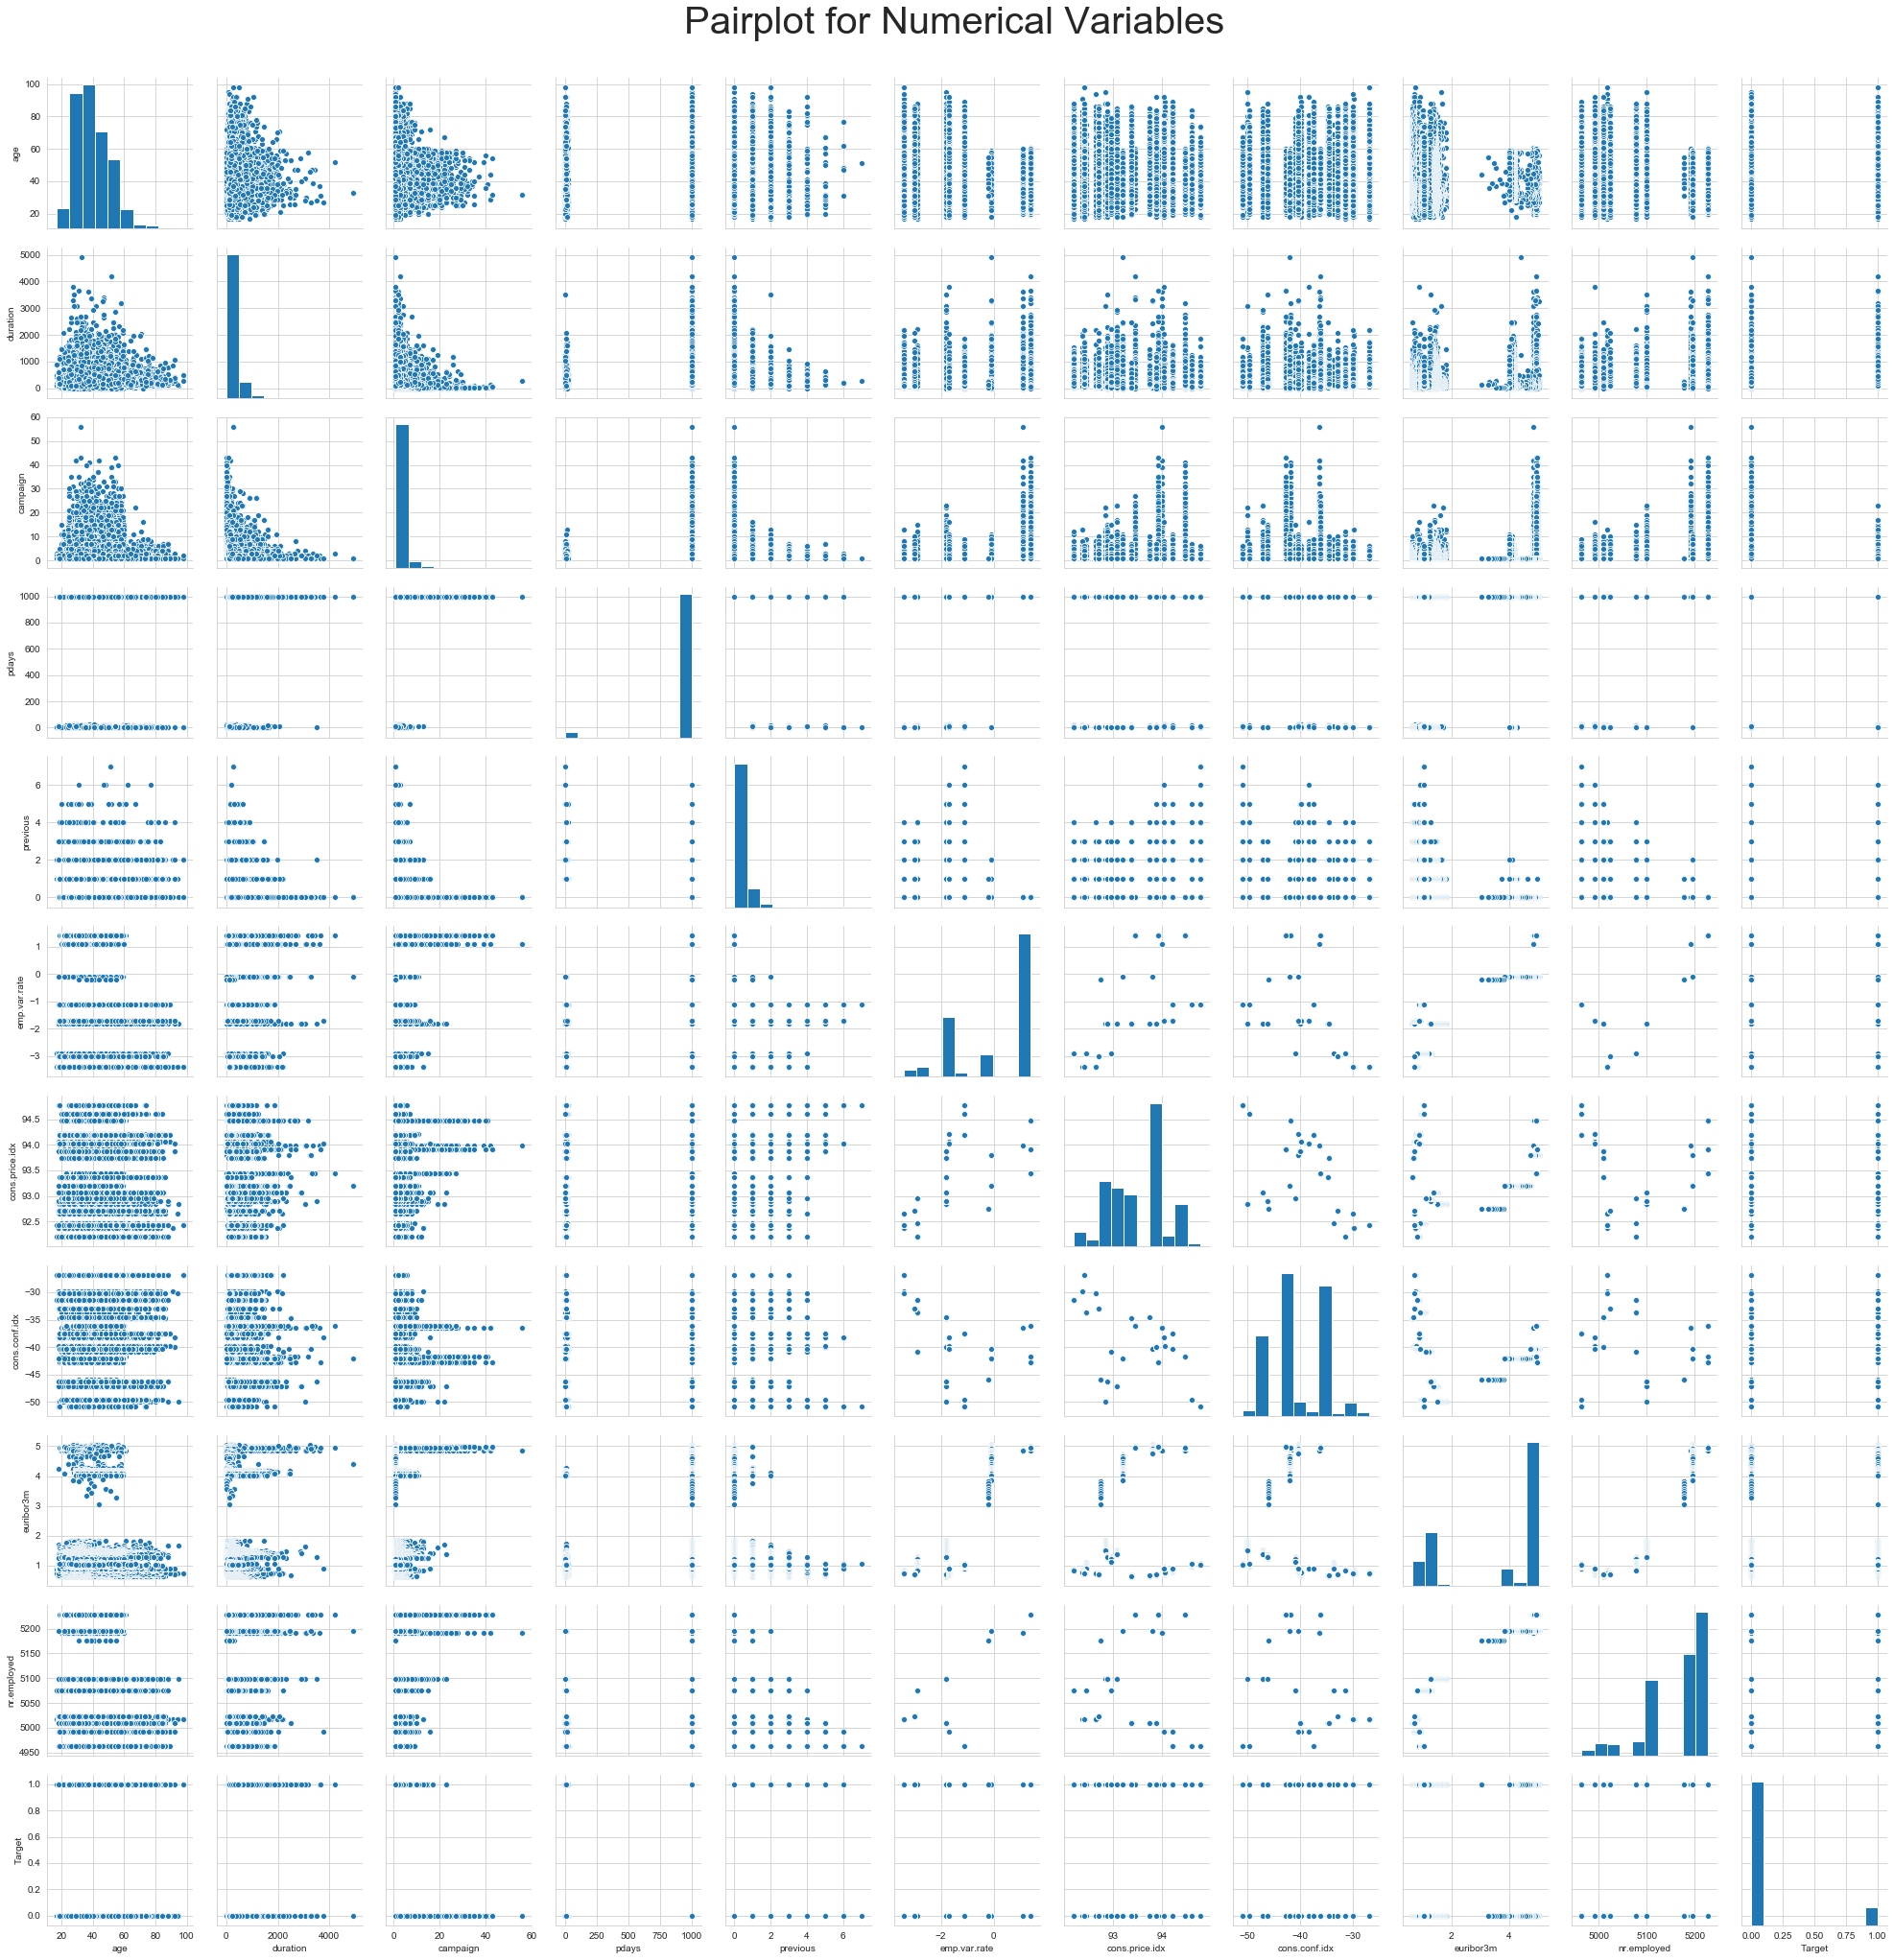

In [10]:
p = sns.pairplot(numeric)
p.fig.suptitle('Pairplot for Numerical Variables', fontsize=40, y=1.03)

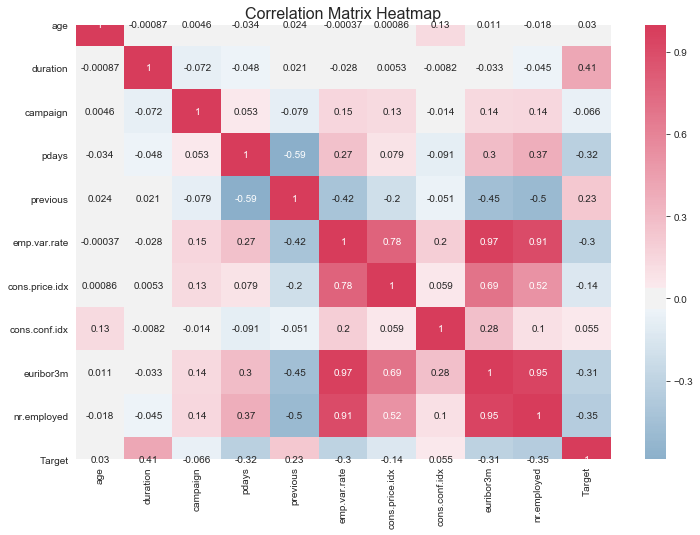

In [11]:
cor_matrix = numeric.corr()

plt.subplots(figsize=(12, 8))
color = sns.diverging_palette(240, 5, as_cmap=True)
sns.heatmap(cor_matrix, cmap=color, vmax=1, center=0, annot=True)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()       

### From the pairplot and the correlation matrix heatmap above, we can see that data is non-linear and asymmetric. 
### Also, no single feature is correlated completely with Target, thus we need to find a combinantion of features.

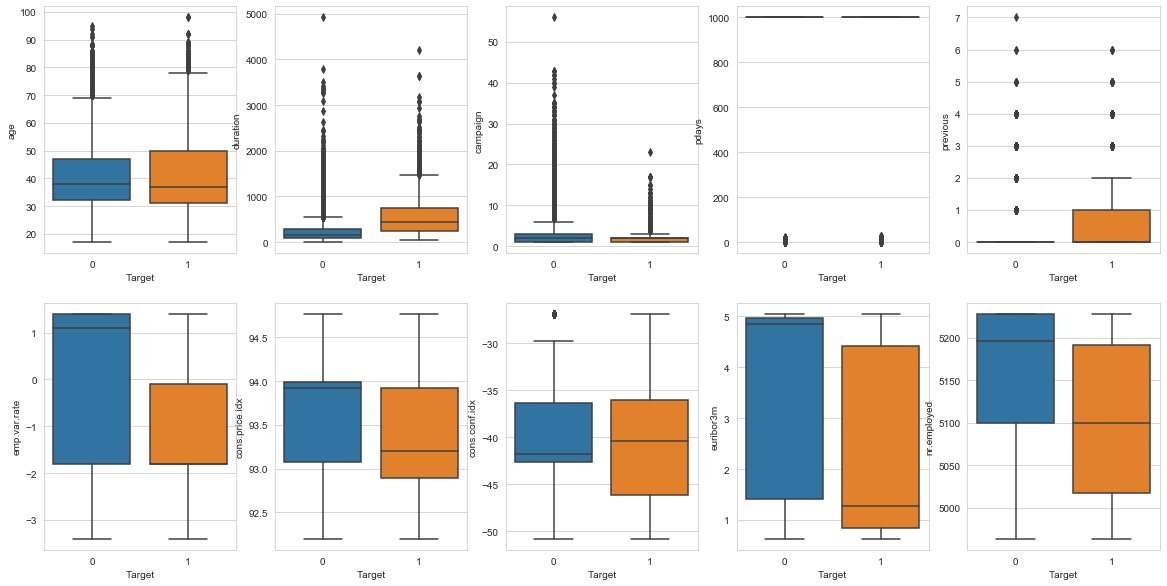

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
ax1 = sns.boxplot(y='age', x='Target', data = bank_df, ax = axs[0][0])
# ax1.set_xlabel('Target')
# ax1.set_xticklabels(['No', 'Yes'])

sns.boxplot(y='duration', x='Target', data = bank_df, ax = axs[0][1])
sns.boxplot(y='campaign', x='Target', data = bank_df, ax = axs[0][2])
sns.boxplot(y='pdays', x='Target', data = bank_df, ax = axs[0][3])
sns.boxplot(y='previous', x='Target', data = bank_df, ax = axs[0][4])
sns.boxplot(y='emp.var.rate', x='Target', data = bank_df, ax = axs[1][0])
sns.boxplot(y='cons.price.idx', x='Target', data = bank_df, ax = axs[1][1])
sns.boxplot(y='cons.conf.idx', x='Target', data = bank_df, ax = axs[1][2])
sns.boxplot(y='euribor3m', x='Target', data = bank_df, ax = axs[1][3])
sns.boxplot(y='nr.employed', x='Target', data = bank_df, ax = axs[1][4])
plt.show()

## Explore Categorical Variables

### **Target** variable

In [13]:
bank_df['Target'].value_counts()

0    36548
1     4640
Name: Target, dtype: int64

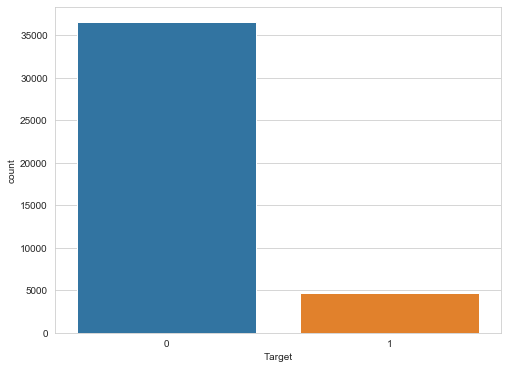

In [14]:
plt.subplots(figsize=(8, 6))
sns.countplot('Target', data=bank_df)

In [15]:
num_yes = bank_df.loc[bank_df['Target']==1, 'Target'].count()
percentage = num_yes / bank_df.shape[0] *100
print('The percentage of success: ', percentage)

The percentage of success:  11.265417111780131


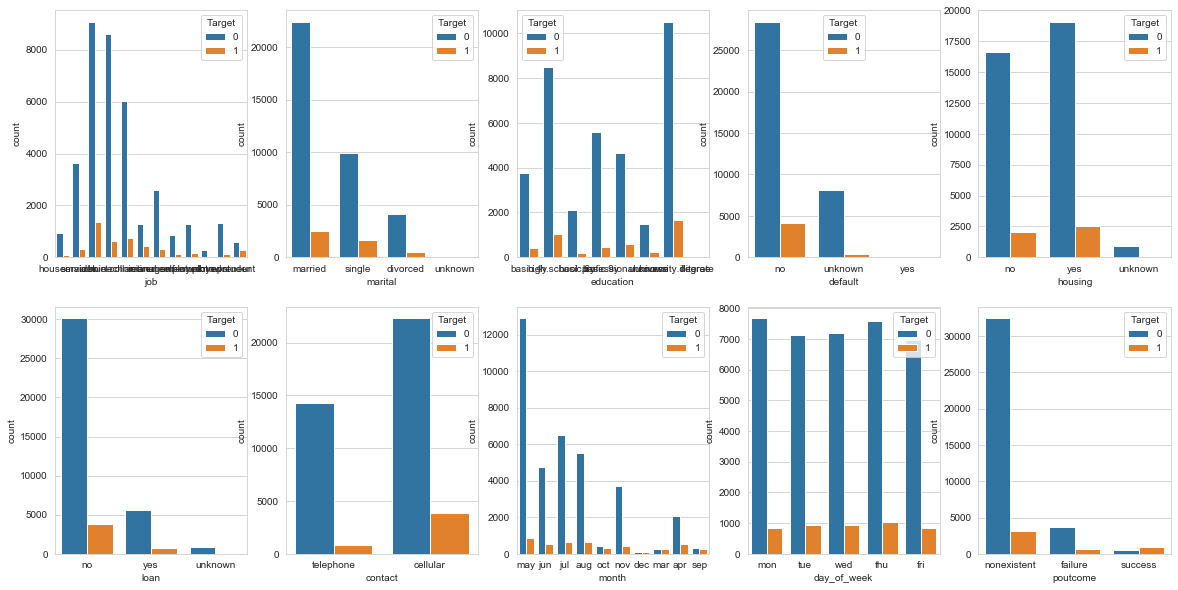

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
ax1 = sns.countplot(x='job', hue='Target', data = bank_df, ax = axs[0][0])
# ax1.set_xlabel('Target')
#ax1.set_xticks(rotation='vertical')

sns.countplot(x='marital', hue='Target', data = bank_df, ax = axs[0][1])
sns.countplot(x='education', hue='Target', data = bank_df, ax = axs[0][2])
sns.countplot(x='default', hue='Target', data = bank_df, ax = axs[0][3])
sns.countplot(x='housing', hue='Target', data = bank_df, ax = axs[0][4])
sns.countplot(x='loan', hue='Target', data = bank_df, ax = axs[1][0])
sns.countplot(x='contact', hue='Target', data = bank_df, ax = axs[1][1])
sns.countplot(x='month', hue='Target', data = bank_df, ax = axs[1][2])
sns.countplot(x='day_of_week', hue='Target', data = bank_df, ax = axs[1][3])
sns.countplot(x='poutcome', hue='Target', data = bank_df, ax = axs[1][4])
plt.show()

### Categorical variables have missing values encoded as 'unknown'

In [17]:
categorics = bank_df.select_dtypes(include="object")
for categ_var in categorics:
    unknownCnt = bank_df.loc[bank_df[categ_var]=='unknown', categ_var].count()
    print('The number of unknown values for ', categ_var, ': ', unknownCnt)

The number of unknown values for  job :  330
The number of unknown values for  marital :  80
The number of unknown values for  education :  1731
The number of unknown values for  default :  8597
The number of unknown values for  housing :  990
The number of unknown values for  loan :  990
The number of unknown values for  contact :  0
The number of unknown values for  month :  0
The number of unknown values for  day_of_week :  0
The number of unknown values for  poutcome :  0


## Imputation

### *Option: Imputation for unknown values using the SimpleImputer with most frequent

In [18]:
# impute = SimpleImputer(missing_values='unknown', strategy='most_frequent')
# categorics = bank_df.select_dtypes(include="object")
# imputMF_df = bank_df.copy()

# for col in categorics:
#     if col != 'default':
#         imputMF_df[col] = impute.fit_transform(imputMF_df[col].values.reshape(-1, 1)) 


# for col in categorics:
#     unknownCnt = imputMF_df.loc[imputMF_df[col]=='unknown', col].count()
#     print('The number of unknown values for ', col, ': ', unknownCnt)

### Since the result shows the almost same prediction accuracy between with and without imputaion, we will keep the data as it is.

# Feature Engineering

In [4]:
categorics = bank_df.select_dtypes(include="object")
bankDummy_df = pd.get_dummies(bank_df, columns=categorics.columns, drop_first=True)
#imputeMFDum_df = pd.get_dummies(imputMF_df, columns=categorics.columns, drop_first=True)

print(bankDummy_df.columns.values)
print(bankDummy_df.shape)

# print(imputeMFDum_df.columns.values)
# print(imputeMFDum_df.shape)

['age' 'duration' 'campaign' 'pdays' 'previous' 'emp.var.rate'
 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed' 'Target'
 'job_blue-collar' 'job_entrepreneur' 'job_housemaid' 'job_management'
 'job_retired' 'job_self-employed' 'job_services' 'job_student'
 'job_technician' 'job_unemployed' 'job_unknown' 'marital_married'
 'marital_single' 'marital_unknown' 'education_basic.6y'
 'education_basic.9y' 'education_high.school' 'education_illiterate'
 'education_professional.course' 'education_university.degree'
 'education_unknown' 'default_unknown' 'default_yes' 'housing_unknown'
 'housing_yes' 'loan_unknown' 'loan_yes' 'contact_telephone' 'month_aug'
 'month_dec' 'month_jul' 'month_jun' 'month_mar' 'month_may' 'month_nov'
 'month_oct' 'month_sep' 'day_of_week_mon' 'day_of_week_thu'
 'day_of_week_tue' 'day_of_week_wed' 'poutcome_nonexistent'
 'poutcome_success']
(41188, 54)


In [5]:
X = bankDummy_df.drop('Target', axis=1)
y = bankDummy_df['Target']

# X_MF = imputeMFDum_df.drop('Target', axis=1)
# y_MF = imputeMFDum_df['Target']

In [6]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
scaled_df = pd.DataFrame(X_scaled)
display(scaled_df.describe())

# X_MF_scaled = min_max_scaler.fit_transform(X_MF)
# scaledMF_df = pd.DataFrame(X_MF_scaled)
# display(scaledMF_df.describe())

0             1             2             3             4   \
count  41188.000000  41188.000000  41188.000000  41188.000000  41188.000000   
mean       0.284248      0.052518      0.028502      0.963439      0.024709   
std        0.128657      0.052720      0.050364      0.187098      0.070700   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.185185      0.020740      0.000000      1.000000      0.000000   
50%        0.259259      0.036600      0.018182      1.000000      0.000000   
75%        0.370370      0.064864      0.036364      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 5             6             7             8             9   \
count  41188.000000  41188.000000  41188.000000  41188.000000  41188.000000   
mean       0.725393      0.535723      0.430854      0.677237      0.769134   
std        0.327283      0.225581      0.193648      0.393210      0.273163   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333333      0.340608      0.338912      0.160961      0.512287   
50%        0.937500      0.603274      0.376569      0.957379      0.859735   
75%        1.000000      0.698753      0.602510      0.980957      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...            43            44            45            46  \
count  ...  41188.000000  41188.000000  41188.000000  41188.000000   
mean   ...      0.334296      0.099568      0.017432      0.013839   
std    ...      0.471750      0.299427      0.130877      0.116824   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      1.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

                 47            48            49            50            51  \
count  41188.000000  41188.000000  41188.000000  41188.000000  41188.000000   
mean       0.206711      0.209357      0.196416      0.197485      0.863431   
std        0.404951      0.406855      0.397292      0.398106      0.343396   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      1.000000   
50%        0.000000      0.000000      0.000000      0.000000      1.000000   
75%        0.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 52  
count  41188.000000  
mean       0.033335  
std        0.179512  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 53 columns]

# Split Data into Training and Test set

In [7]:
X_Train, X_Test, y_Train, y_Test = train_test_split(scaled_df, y, test_size=0.1, random_state=0)

print("Original X: ", scaled_df.shape)
print("X_Train: ", X_Train.shape)
print("X_Test: ", X_Test.shape)
print("Y_Train: ", y_Train.shape)
print("Y_Test: ", y_Test.shape)

Original X:  (41188, 53)
X_Train:  (37069, 53)
X_Test:  (4119, 53)
Y_Train:  (37069,)
Y_Test:  (4119,)


### We will save 10% of data to test our final model at the end of this project

# Comparison Original data with Balanced data

## With Original Data

In [23]:
clfs = []
clfs.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
#clfs.append(('DT', DecisionTreeClassifier()))
#clfs.append(('KNN', KNeighborsClassifier()))
clfs.append(('NN', MLPClassifier(max_iter=1000)))
clfs.append(('RF', RandomForestClassifier(n_estimators=50)))
#clfs.append(('SVM', SVC(gamma='scale')))

In [24]:
skf = StratifiedKFold(n_splits=5)

f1 = {}
models = []
for name, clf in clfs:
    f1[name] = []
    for trainIndex, testIndex in skf.split(X_Train, y_Train):
        xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
        yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

        clf.fit(xTrain, yTrain)
        yPred = clf.predict(xTest)
        f1[name].append(f1_score(yTest, yPred))
        
    models.append(name)
    print("%s: %f" % (name, np.mean(f1[name])))

LR: 0.491054
NN: 0.518869
RF: 0.544089


## With 4 Balanced Data using 4 Different Resampling Methods

### 1. Using Random Under-Sampling

In [25]:
from imblearn.under_sampling import RandomUnderSampler

f1 = {}
models = []
for name, clf in clfs:
    f1[name] = []
    for trainIndex, testIndex in skf.split(X_Train, y_Train):
        xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
        yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

        # Random under-sampling
        rus = RandomUnderSampler()
        xTrain_rus, yTrain_rus = rus.fit_sample(xTrain, yTrain)
        
        clf.fit(xTrain_rus, yTrain_rus)
        yPred = clf.predict(xTest)
        f1[name].append(f1_score(yTest, yPred))
        
    models.append(name)
    print("%s: %f" % (name, np.mean(f1[name])))

LR: 0.576196
NN: 0.546399
RF: 0.586289


### 2. Using Random Over-Sampling

In [26]:
from imblearn.over_sampling import RandomOverSampler

f1 = {}
models = []
for name, clf in clfs:
    f1[name] = []
    for trainIndex, testIndex in skf.split(X_Train, y_Train):
        xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
        yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

        # Random over-sampling
        ros = RandomOverSampler()
        xTrain_ros, yTrain_ros = ros.fit_sample(xTrain, yTrain)
        
        clf.fit(xTrain_ros, yTrain_ros)
        yPred = clf.predict(xTest)
        f1[name].append(f1_score(yTest, yPred))
        
    models.append(name)
    print("%s: %f" % (name, np.mean(f1[name])))

LR: 0.585338
NN: 0.548968
RF: 0.597164


### 3. Using Under-Sampling: Tomek links

In [27]:
from imblearn.under_sampling import TomekLinks

f1 = {}
models = []
for name, clf in clfs:
    f1[name] = []
    for trainIndex, testIndex in skf.split(X_Train, y_Train):
        xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
        yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

        # Under-sampling using Tomek links
        tl = TomekLinks(ratio='majority')
        xTrain_tl, yTrain_tl = tl.fit_sample(xTrain, yTrain)
        
        clf.fit(xTrain_tl, yTrain_tl)
        yPred = clf.predict(xTest)
        f1[name].append(f1_score(yTest, yPred))
        
    models.append(name)
    print("%s: %f" % (name, np.mean(f1[name])))

LR: 0.517237
NN: 0.545084
RF: 0.579852


### 4. Using Over-Sampling: SMOTE

In [28]:
f1 = {}
models = []
for name, clf in clfs:
    f1[name] = []
    for trainIndex, testIndex in skf.split(X_Train, y_Train):
        xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
        yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

        # Over-sampling using SMOTE
        smote = SMOTE(random_state=1, ratio = 1.0)
        xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
        
        clf.fit(xTrain_smote, yTrain_smote)
        yPred = clf.predict(xTest)
        f1[name].append(f1_score(yTest, yPred))
        
    models.append(name)
    print("%s: %f" % (name, np.mean(f1[name])))

LR: 0.590713
NN: 0.532270
RF: 0.598057


### With four resampling methods, all three models (LR, NN, and RF) have better F1-scores than ones with original data. 
### Especially, using SMOTE method has the best performance among four methods. Random Forest Model has the best mean F1-score and LR is the second best.

## Over-sampling: SMOTE (Synthetic Minority Oversampling Technique)

In [29]:
smote = SMOTE(random_state=1, ratio = 1.0)
xTrain_smote, yTrain_smote = smote.fit_sample(X_Train, y_Train)

Text(0.5, 1.0, 'Target Count with NO SMOTE')

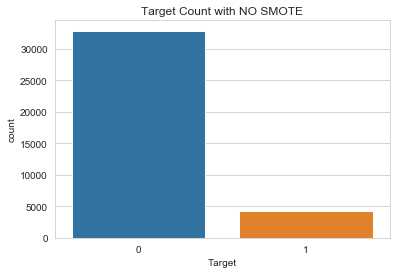

In [30]:
plt.subplots()
sns.countplot(y_Train)
plt.title('Target Count with NO SMOTE')

Text(0.5, 1.0, 'Target Count using SMOTE')

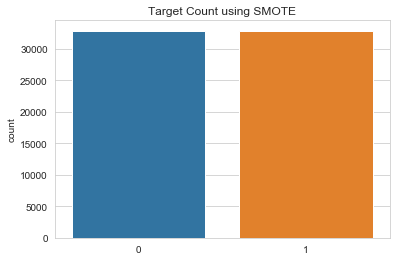

In [31]:
plt.subplots()
sns.countplot(yTrain_smote)
plt.title('Target Count using SMOTE')

# Feature Selection with SMOTE and 5-fold CV

## 1. Using SelectKBest 

In [32]:
skf = StratifiedKFold(n_splits=5)

scores = []
f1 = []
features = []
i = 1
for trainIndex, testIndex in skf.split(X_Train, y_Train):
    xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    # Perfoming feature selection
    select = SelectKBest(score_func=f_classif, k=15)
    fit = select.fit(xTrain_smote, yTrain_smote)
    scores.append(fit.scores_)
    features.append(X.columns[fit.get_support()])

    score_df = pd.DataFrame(fit.scores_)
    cols_df = pd.DataFrame(X.columns[fit.get_support()])
    select_df = pd.concat([cols_df, score_df], axis=1)
    select_df.columns = ['Variable','Score']  
    print('Fold ', i)
    print(select_df[:15].sort_values('Score', ascending=False),'\n')
    
    sel_cols = xTrain.columns[fit.get_support()]
    xTrain_smote = xTrain_smote[:, sel_cols]
    xTest = xTest.iloc[:, sel_cols]
    
    # Logistic Regression is a base classifier used to evaluate a subset of attributes
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1_cv = f1_score(yTest, yPred)
    f1.append(f1_cv)
    i += 1
    
print("For LR using SelectKBest and SOMTE, mean F1-socre: ", np.mean(f1))

Fold  1
                Variable         Score
1               campaign  16355.267650
9      contact_telephone  14551.565547
8        default_unknown  13395.033666
5         cons.price.idx  12274.221327
3               previous   5554.934532
4           emp.var.rate   3757.223593
6              euribor3m   2570.750346
2                  pdays    930.168979
10             month_mar    921.263006
14      poutcome_success    699.277795
7            nr.employed    118.156398
11             month_may     82.429912
0               duration     38.420833
12             month_oct     31.679018
13  poutcome_nonexistent      0.042210 

Fold  2
                Variable         Score
1                  pdays  16511.887042
9              month_mar  14792.888121
8      contact_telephone  13592.504586
5              euribor3m  12172.471015
3           emp.var.rate   5436.761813
4         cons.price.idx   3565.743276
6            nr.employed   2357.867383
14      poutcome_success    874.178160
2      

In [33]:
KbestTrain = X_Train.copy()
KbestTrain.columns = X.columns
KbestCols = list(features[0])
print("Selected features: \n", KbestCols)
Kbest_X_Train = KbestTrain[KbestCols]
#Kbest_X_Train = X_Test[KbestCols]

Selected features: 
 ['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed', 'default_unknown', 'contact_telephone', 'month_mar', 'month_may', 'month_oct', 'poutcome_nonexistent', 'poutcome_success']


### Evaluation using SelectKBest

In [34]:
print('For RF using SelectKBest and SOMTE,\n')
f1 = []
for trainIndex, testIndex in skf.split(Kbest_X_Train, y_Train):
    xTrain, xTest = Kbest_X_Train.iloc[trainIndex], Kbest_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
 
    model = RandomForestClassifier(n_estimators=50)
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1.append(f1_score(yTest, yPred))
        
print("Mean F1-socre: ", np.mean(f1))

For RF using SelectKBest and SOMTE,

Mean F1-socre:  0.5766586165653462


## 2. Using Recursive Feature Elimination 

In [35]:
votes = []
f1 = []
support = []
for trainIndex, testIndex in skf.split(X_Train, y_Train):
    xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    # Perfoming feature selection
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    rfe = RFE(model, 15)
    rfe = rfe.fit(xTrain_smote, yTrain_smote)
    
    xTrain_smote = rfe.transform(xTrain_smote)
    xTest = rfe.transform(xTest)
    
    votes.append(rfe.ranking_)
    support.append(rfe.support_)
    
    # create a base classifier used to evaluate a subset of attributes
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1.append(f1_score(yTest, yPred))

print("For LR using RFE and SMOTE, mean F1-socre: ", np.mean(f1), "\n")

For LR using RFE and SMOTE, mean F1-socre:  0.5827025611235859 



In [36]:
sorted_rank = pd.DataFrame(votes).mean(axis=0).sort_values()
cols_df = pd.DataFrame(X.columns)
select_df = pd.concat([cols_df, sorted_rank], axis=1)
select_df.columns = ['Variable','Rank']  
print(select_df.nsmallest(15, 'Rank'))  

                Variable  Rank
1               duration   1.0
2               campaign   1.0
3                  pdays   1.0
5           emp.var.rate   1.0
6         cons.price.idx   1.0
8              euribor3m   1.0
38             month_aug   1.0
41             month_jun   1.0
42             month_mar   1.0
43             month_may   1.0
44             month_nov   1.0
52      poutcome_success   1.0
51  poutcome_nonexistent   1.8
31       default_unknown   3.6
4               previous   3.8


In [37]:
rfe_X_Train = X_Train.iloc[:,[1,2,3,5,6,8,38,41,42,43,44,52,51,31,4]]
#rfe_X_Test = X_Test.iloc[:,[1,2,3,5,6,8,38,41,42,43,44,52,51,31,4]]

### Evaluation using RFE

In [38]:
print('For RF using RFE and SOMTE,\n')
f1 = []
for trainIndex, testIndex in skf.split(rfe_X_Train, y_Train):
    xTrain, xTest = rfe_X_Train.iloc[trainIndex], rfe_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
  
    model = RandomForestClassifier(n_estimators=50)
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1.append(f1_score(yTest, yPred))
        
print("Mean F1-socre: ", np.mean(f1))

For RF using RFE and SOMTE,

Mean F1-socre:  0.5743332851211942


## 3. Using Extra Trees Classifier

In [9]:
fi = []
features = []
f1 = []
for trainIndex, testIndex in skf.split(X_Train, y_Train):
    xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    # Fit an Extra Trees model to the data
    etc = ExtraTreesClassifier(n_estimators=50)
    etc.fit(xTrain_smote, yTrain_smote)
    fi.append(etc.feature_importances_)
    
    sfm = SelectFromModel(etc, prefit=True)
    xTrain_smote = sfm.transform(xTrain_smote)
    xTest = sfm.transform(xTest)
    idx = sfm.get_support()
    col_name = X.columns[idx]
    #n_features = sfm.transform(xTrain).shape[1]
    features.append(col_name)  
     
    # create a base classifier used to evaluate a subset of attributes
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1.append(f1_score(yTest, yPred))

print("For LR using Extra Trees and SMOTE, mean F1-socre: ", np.mean(f1), "\n")
# Display the relative importance of each attribute
fi_df = pd.DataFrame(fi).mean(axis = 0).sort_values(ascending=False)
print(fi_df.head(15))
print(pd.DataFrame(features))

For LR using Extra Trees and SMOTE, mean F1-socre:  0.5775218896254358 

1     0.248517
8     0.095155
9     0.056249
5     0.050053
0     0.034286
2     0.031816
34    0.027127
43    0.026642
37    0.025094
31    0.024729
3     0.020759
52    0.019898
36    0.018537
7     0.017488
6     0.017063
dtype: float64
     0         1         2             3              4            5  \
0  age  duration  campaign  emp.var.rate      euribor3m  nr.employed   
1  age  duration  campaign  emp.var.rate  cons.conf.idx    euribor3m   
2  age  duration  campaign  emp.var.rate      euribor3m  nr.employed   
3  age  duration  campaign         pdays   emp.var.rate    euribor3m   
4  age  duration  campaign         pdays   emp.var.rate    euribor3m   

                 6                7                  8                  9  \
0  default_unknown      housing_yes           loan_yes  contact_telephone   
1      nr.employed  default_unknown        housing_yes  contact_telephone   
2  default_unknown     

In [10]:
cols_df = pd.DataFrame(X.columns)
new_fi_df = pd.concat([cols_df, fi_df], axis=1)
new_fi_df.columns = ['Variable','Feature Importance']  
selected_df = new_fi_df.nlargest(15, 'Feature Importance')
etcCols = list(selected_df.Variable.unique())
print(etcCols, "\n")
print(selected_df)  

['duration', 'euribor3m', 'nr.employed', 'emp.var.rate', 'age', 'campaign', 'housing_yes', 'month_may', 'contact_telephone', 'default_unknown', 'pdays', 'poutcome_success', 'loan_yes', 'cons.conf.idx', 'cons.price.idx'] 

             Variable  Feature Importance
1            duration            0.248517
8           euribor3m            0.095155
9         nr.employed            0.056249
5        emp.var.rate            0.050053
0                 age            0.034286
2            campaign            0.031816
34        housing_yes            0.027127
43          month_may            0.026642
37  contact_telephone            0.025094
31    default_unknown            0.024729
3               pdays            0.020759
52   poutcome_success            0.019898
36           loan_yes            0.018537
7       cons.conf.idx            0.017488
6      cons.price.idx            0.017063


In [11]:
etcTrain = X_Train.copy()
etcTrain.columns = X.columns
#etcTest.columns = X.columns
etc_X_Train = etcTrain[etcCols]
#etc_X_Test = etcTest[etcCols]

### Evaluation using ETC

In [42]:
print('For RF using Extra Trees and SOMTE,\n')
f1 = []
for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    model = RandomForestClassifier(n_estimators=50)
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1.append(f1_score(yTest, yPred))
        
print("Mean F1-socre: ", np.mean(f1))

For RF using Extra Trees and SOMTE,

Mean F1-socre:  0.6097180790677242


## 4. Using Lasso Regression

In [43]:
coefs  = pd.DataFrame()
coefs  = coefs.reindex(X.columns)
f1  = []

for trainIndex, testIndex in skf.split(X_Train, y_Train):
    xTrain, xTest = X_Train.iloc[trainIndex], X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    # Perfoming feature selection
    lasso = Lasso(alpha=0.001, max_iter=10e3).fit(xTrain_smote, yTrain_smote)
    coefs = pd.concat([coefs, pd.DataFrame(data=lasso.coef_, index=X.columns)], axis=1)
 
    # create a base classifier used to evaluate a subset of attributes
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1.append(f1_score(yTest, yPred))
    
print("For LR using Lasso and SMOTE, mean F1-socre: ", np.mean(f1), "\n")

coefs["Mean"] = coefs.mean(axis=1)
coefs["Min"] = coefs.min(axis=1)

goodCols = coefs[coefs["Mean"]>0].index.tolist()
goodIdxs = coefs[coefs["Mean"]>0].index.tolist()
goodCols

For LR using Lasso and SMOTE, mean F1-socre:  0.5907129276011949 



['duration',
 'cons.price.idx',
 'cons.conf.idx',
 'job_retired',
 'job_student',
 'marital_married',
 'marital_single',
 'education_university.degree',
 'housing_yes',
 'month_mar',
 'day_of_week_wed',
 'poutcome_nonexistent',
 'poutcome_success']

In [44]:
coefs[coefs["Mean"]>0]['Mean'].sort_values(ascending=False)

duration                       3.699736
month_mar                      0.159210
poutcome_nonexistent           0.088475
poutcome_success               0.085177
cons.price.idx                 0.035139
cons.conf.idx                  0.034952
job_retired                    0.033200
education_university.degree    0.028744
job_student                    0.022929
day_of_week_wed                0.010843
marital_single                 0.008079
housing_yes                    0.001719
marital_married                0.000939
Name: Mean, dtype: float64

In [45]:
lassoTrain = X_Train.copy()
lassoTrain.columns = X.columns
#lassoTest.columns = X.columns
lasso_X_Train = lassoTrain[goodCols]
#lasso_X_Test = lassoTest[goodCols]

### Evaluation using Lasso

In [46]:
print('For RF using Lasso and SOMTE,\n')
f1 = []
for trainIndex, testIndex in skf.split(lasso_X_Train, y_Train):
    xTrain, xTest = lasso_X_Train.iloc[trainIndex], lasso_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    model = RandomForestClassifier(n_estimators=50)
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1.append(f1_score(yTest, yPred))
    
print("Mean F1-socre: ", np.mean(f1))

For RF using Lasso and SOMTE,

Mean F1-socre:  0.5489683394011438


## 5. Combining all the four methods

In [47]:
combCols = ['duration', 'euribor3m', 'contact_telephone', 'campaign', 'poutcome_success', 'default_unknown',\
          'cons.price.idx', 'cons.conf.idx', 'month_may', 'month_mar', 'poutcome_nonexistent','previous',\
          'pdays','emp.var.rate', 'nr.employed']
combTrain = X_Train.copy()
combTrain.columns = X.columns
#combTest.columns = X.columns
comb_X_Train = combTrain[combCols]
#comb_X_Test = combTest[combCols]

### Evaluation using Combined Features

In [48]:
print('For RF combining four methods and SOMTE,\n')
f1 = []
for trainIndex, testIndex in skf.split(comb_X_Train, y_Train):
    xTrain, xTest = comb_X_Train.iloc[trainIndex], comb_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]

    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    model = RandomForestClassifier(n_estimators=50)
    model.fit(xTrain_smote, yTrain_smote)
    yPred = model.predict(xTest)
    f1.append(f1_score(yTest, yPred))
        
print("Mean F1-socre: ", np.mean(f1))

For RF combining four methods and SOMTE,

Mean F1-socre:  0.57187935528986


### Random Forest model with features selected from Extra Tree Claasifier has the highest F1-score.

# STEP 2. Modeling with Best Features

## 1. Logistic Regression

In [49]:
accs = {}
f1s = {}
mccs = {}
cms = {}
aucs = {}

In [50]:
accs['LR'] = []
f1s['LR'] = []
mccs['LR'] = []
cms['LR'] = []
aucs['LR'] = []

for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(xTrain_smote, yTrain_smote)  
    yPred = clf.predict(xTest)
    yProb = clf.predict_proba(xTest)[:,1]
    
    # All Scores
    accs['LR'].append(accuracy_score(yTest, yPred))
    f1s['LR'].append(f1_score(yTest, yPred))
    mccs['LR'].append(matthews_corrcoef(yTest, yPred))
    cms['LR'].append(confusion_matrix(yTest,yPred))
    aucs['LR'].append(roc_auc_score(yTest,yProb))
    
print("For Logistic Regression with the selected features,")
print("Mean Accuracy                        : ", np.mean(accs['LR']))
print("Mean F1-Score                        : ", np.mean(f1s['LR']))
print("Mean Matthews Correlation Coefficient: ", np.mean(mccs['LR']))
print("Mean Confusion Matrices              : ", np.mean(cms['LR']))
print("Mean ROC-AUC Score                   : ", np.mean(aucs['LR']))

For Logistic Regression with the selected features,
Mean Accuracy                        :  0.8534083861866246
Mean F1-Score                        :  0.5722437870511751
Mean Matthews Correlation Coefficient:  0.5415316763059121
Mean Confusion Matrices              :  1853.45
Mean ROC-AUC Score                   :  0.9321633412559731


## 2. Decision Tree

In [51]:
accs['DT'] = []
f1s['DT'] = []
mccs['DT'] = []
cms['DT'] = []
aucs['DT'] = []

for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Oversampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    clf = DecisionTreeClassifier()
    clf.fit(xTrain_smote, yTrain_smote)  
    yPred = clf.predict(xTest)
    yProb = clf.predict_proba(xTest)[:,1]
    
    # All Scores
    accs['DT'].append(accuracy_score(yTest, yPred))
    f1s['DT'].append(f1_score(yTest, yPred))
    mccs['DT'].append(matthews_corrcoef(yTest, yPred))
    cms['DT'].append(confusion_matrix(yTest,yPred))
    aucs['DT'].append(roc_auc_score(yTest, yProb))
            
print("\nFor Decision Trees with the selected features, ")
print("Mean Accuracy                        : ", np.mean(accs['DT']))
print("Mean F1-Score                        : ", np.mean(f1s['DT']))
print("Mean Matthews Correlation Coefficient: ", np.mean(mccs['DT']))
print("Mean Confusion Matrices              : ", np.mean(cms['DT']))
print("Mean ROC-AUC Score                   : ", np.mean(aucs['DT']))


For Decision Trees with the selected features, 
Mean Accuracy                        :  0.880304239418423
Mean F1-Score                        :  0.5280445683245187
Mean Matthews Correlation Coefficient:  0.46411728965446314
Mean Confusion Matrices              :  1853.45
Mean ROC-AUC Score                   :  0.754901776336081


## 3. K-Nearest Neighbors

In [52]:
accs['KNN'] = []
f1s['KNN'] = []
mccs['KNN'] = []
cms['KNN'] = []
aucs['KNN'] = []

for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    clf = KNeighborsClassifier()
    clf.fit(xTrain_smote, yTrain_smote)  
    yPred = clf.predict(xTest)
    yProb = clf.predict_proba(xTest)[:,1]
    
    # All Scores
    accs['KNN'].append(accuracy_score(yTest, yPred))
    f1s['KNN'].append(f1_score(yTest, yPred))
    mccs['KNN'].append(matthews_corrcoef(yTest, yPred))
    cms['KNN'].append(confusion_matrix(yTest,yPred))
    aucs['KNN'].append(roc_auc_score(yTest, yProb))

print("\nFor K-Nearnest Neighbors with the selected features,")
print("Mean Accuracy                        : ", np.mean(accs['KNN']))
print("Mean F1-Score                        : ", np.mean(f1s['KNN']))
print("Mean Matthews Correlation Coefficient: ", np.mean(mccs['KNN']))
print("Mean Confusion Matrices              : ", np.mean(cms['KNN']))
print("Mean ROC-AUC Score                   : ", np.mean(aucs['KNN']))


For K-Nearnest Neighbors with the selected features,
Mean Accuracy                        :  0.8530037171932217
Mean F1-Score                        :  0.5449125998179305
Mean Matthews Correlation Coefficient:  0.49859119774798016
Mean Confusion Matrices              :  1853.45
Mean ROC-AUC Score                   :  0.8752799805225976


## 4. Neural Network

In [53]:
accs['NN'] = []
f1s['NN'] = []
mccs['NN'] = []
cms['NN'] = []
aucs['NN'] = []
for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    clf = MLPClassifier(max_iter=1000)
    clf.fit(xTrain_smote, yTrain_smote)  
    yPred = clf.predict(xTest)
    yProb = clf.predict_proba(xTest)[:,1]
    
    # All Scores
    accs['NN'].append(accuracy_score(yTest, yPred))
    f1s['NN'].append(f1_score(yTest, yPred))
    mccs['NN'].append(matthews_corrcoef(yTest, yPred))
    cms['NN'].append(confusion_matrix(yTest,yPred))
    aucs['NN'].append(roc_auc_score(yTest, yProb))
    
print("\nFor Neural Network with the selected features")
print("Mean Accuracy                        : ", np.mean(accs['NN']))
print("Mean F1-Score                        : ", np.mean(f1s['NN']))
print("Mean Matthews Correlation Coefficient: ", np.mean(mccs['NN']))
print("Mean Confusion Matrices              : ", np.mean(cms['NN']))
print("Mean ROC-AUC Score                   : ", np.mean(aucs['NN']))


For Neural Network with the selected features
Mean Accuracy                        :  0.8569692207264129
Mean F1-Score                        :  0.58571291513202
Mean Matthews Correlation Coefficient:  0.5602115895482341
Mean Confusion Matrices              :  1853.45
Mean ROC-AUC Score                   :  0.9385556474887806


## 5. Random Forest 

In [54]:
accs['RF'] = []
f1s['RF'] = []
mccs['RF'] = []
cms['RF'] = []
aucs['RF'] = []
for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    clf = RandomForestClassifier(n_estimators=50)
    clf.fit(xTrain_smote, yTrain_smote)  
    yPred = clf.predict(xTest)
    yProb = clf.predict_proba(xTest)[:,1]
    
    # All Scores
    accs['RF'].append(accuracy_score(yTest, yPred))
    f1s['RF'].append(f1_score(yTest, yPred))
    mccs['RF'].append(matthews_corrcoef(yTest, yPred))
    cms['RF'].append(confusion_matrix(yTest,yPred))
    aucs['RF'].append(roc_auc_score(yTest, yProb))
    
print("\nFor Random Forest with the selected features")
print("Mean Accuracy                        : ", np.mean(accs['RF']))
print("Mean F1-Score                        : ", np.mean(f1s['RF']))
print("Mean Matthews Correlation Coefficient: ", np.mean(mccs['RF']))
print("Mean Confusion Matrices              : ", np.mean(cms['RF']))
print("Mean ROC-AUC Score                   : ", np.mean(aucs['RF']))


For Random Forest with the selected features
Mean Accuracy                        :  0.9003209600971086
Mean F1-Score                        :  0.6080972997892754
Mean Matthews Correlation Coefficient:  0.5564902519343804
Mean Confusion Matrices              :  1853.45
Mean ROC-AUC Score                   :  0.9357273462427693


## 6. Support Vector Machine (SVM)

In [55]:
accs['SVM'] = []
f1s['SVM'] = []
mccs['SVM'] = []
cms['SVM'] = []
aucs['SVM'] = []
for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    clf = SVC(gamma='scale', probability=True)
    clf.fit(xTrain_smote, yTrain_smote)  
    yPred = clf.predict(xTest)
    yProb = clf.predict_proba(xTest)[:,1]
    
    # All Scores
    accs['SVM'].append(accuracy_score(yTest, yPred))
    f1s['SVM'].append(f1_score(yTest, yPred))
    mccs['SVM'].append(matthews_corrcoef(yTest, yPred))
    cms['SVM'].append(confusion_matrix(yTest,yPred))
    aucs['SVM'].append(roc_auc_score(yTest, yProb))
    
print("\nFor SVM with the selected features")
print("Mean Accuracy                        : ", np.mean(accs['SVM']))
print("Mean F1-Score                        : ", np.mean(f1s['SVM']))
print("Mean Matthews Correlation Coefficient: ", np.mean(mccs['SVM']))
print("Mean Confusion Matrices              : ", np.mean(cms['SVM']))
print("Mean ROC-AUC Score                   : ", np.mean(aucs['SVM']))


For SVM with the selected features
Mean Accuracy                        :  0.8314222653055093
Mean F1-Score                        :  0.5521447499501313
Mean Matthews Correlation Coefficient:  0.5318625232397233
Mean Confusion Matrices              :  1853.45
Mean ROC-AUC Score                   :  0.931176787433136


## 7. Gradient Boosting 

In [56]:
accs['GB'] = []
f1s['GB'] = []
mccs['GB'] = []
cms['GB'] = []
aucs['GB'] = []
for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    clf = GradientBoostingClassifier(random_state=0)
    clf.fit(xTrain_smote, yTrain_smote)  
    yPred = clf.predict(xTest)
    yProb = clf.predict_proba(xTest)[:,1]
    
    # All Scores
    accs['GB'].append(accuracy_score(yTest, yPred))
    f1s['GB'].append(f1_score(yTest, yPred))
    mccs['GB'].append(matthews_corrcoef(yTest, yPred))
    cms['GB'].append(confusion_matrix(yTest,yPred))
    aucs['GB'].append(roc_auc_score(yTest, yProb))
    
print("\nFor Gradient Boosting with the selected features")
print("Mean Accuracy                        : ", np.mean(accs['GB']))
print("Mean F1-Score                        : ", np.mean(f1s['GB']))
print("Mean Matthews Correlation Coefficient: ", np.mean(mccs['GB']))
print("Mean Confusion Matrices              : ", np.mean(cms['GB']))
print("Mean ROC-AUC Score                   : ", np.mean(aucs['GB']))


For Gradient Boosting with the selected features
Mean Accuracy                        :  0.8790903489228944
Mean F1-Score                        :  0.6155517568557232
Mean Matthews Correlation Coefficient:  0.5830232141902825
Mean Confusion Matrices              :  1853.45
Mean ROC-AUC Score                   :  0.9423544270731743


## 8. Adaptive Boosting

In [57]:
accs['AB'] = []
f1s['AB'] = []
mccs['AB'] = []
cms['AB'] = []
aucs['AB'] = []
for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    clf = AdaBoostClassifier(random_state=4)
    clf.fit(xTrain_smote, yTrain_smote)  
    yPred = clf.predict(xTest)
    yProb = clf.predict_proba(xTest)[:,1]
    
    # All Scores
    accs['AB'].append(accuracy_score(yTest, yPred))
    f1s['AB'].append(f1_score(yTest, yPred))
    mccs['AB'].append(matthews_corrcoef(yTest, yPred))
    cms['AB'].append(confusion_matrix(yTest,yPred))
    aucs['AB'].append(roc_auc_score(yTest, yProb))
    
print("\nFor Adaptive Boosting with the selected features")
print("Mean Accuracy                        : ", np.mean(accs['AB']))
print("Mean F1-Score                        : ", np.mean(f1s['AB']))
print("Mean Matthews Correlation Coefficient: ", np.mean(mccs['AB']))
print("Mean Confusion Matrices              : ", np.mean(cms['AB']))
print("Mean ROC-AUC Score                   : ", np.mean(aucs['AB']))


For Adaptive Boosting with the selected features
Mean Accuracy                        :  0.8837840441153458
Mean F1-Score                        :  0.6070707131611048
Mean Matthews Correlation Coefficient:  0.5650323558544292
Mean Confusion Matrices              :  1853.45
Mean ROC-AUC Score                   :  0.9295245529738736


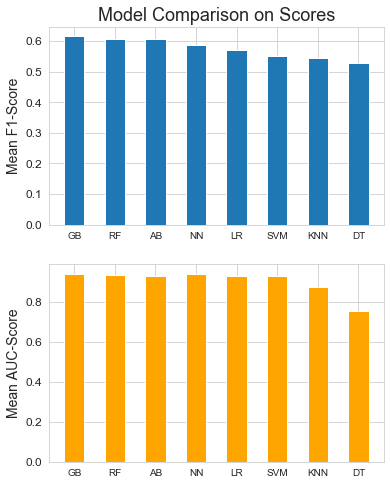

In [58]:
clfs = []
clfs.append('LR')
clfs.append('DT')
clfs.append('KNN')
clfs.append('NN')
clfs.append('RF')
clfs.append('SVM')
clfs.append('GB')
clfs.append('AB')

mean_f1 = []
mean_auc = []
for model in clfs:
    mean_f1.append(np.mean(f1s[model]))
    mean_auc.append(np.mean(aucs[model]))

model_df = pd.DataFrame({'Model': clfs, 'F1': mean_f1, 'AUC': mean_auc})

plt.figure(figsize=(6, 8))
width = 0.5

sort_f1_df = model_df.sort_values('F1', ascending = False)
ax1 = plt.subplot(2, 1, 1)
plt.bar(sort_f1_df['Model'], sort_f1_df['F1'], width)
plt.ylabel('Mean F1-Score', fontsize=14) 
plt.yticks(size = 12)
plt.title('Model Comparison on Scores', size = 18)

sort_auc_df = model_df.sort_values('AUC', ascending = False)
ax1 = plt.subplot(2, 1, 2, sharex=ax1)
plt.bar(sort_f1_df['Model'], sort_f1_df['AUC'], width, color='orange')
plt.ylabel('Mean AUC-Score', fontsize=14) 
plt.yticks(size = 12)

plt.show()

### As shown above, our best model is the Gradient Boosting Model with the highest F1- and ROC-AUC score among eight models.

# STEP 3. Hyper-paremeter Tuning for GB Model

## 1. Find the optimum combination of learning_rate and n_estimators first

In [59]:
aucs = {}
rates = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2]
for rate in rates:
    for estimator in range(40, 81, 10):
        for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
            xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
            yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
            # Over-sampling using SMOTE
            smote = SMOTE(random_state=1, ratio = 1.0)
            xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
            clf = GradientBoostingClassifier(learning_rate=rate, n_estimators=estimator, min_samples_split=100,\
                                             min_samples_leaf=30, max_depth=5, max_features='sqrt', random_state=0)
            clf.fit(xTrain_smote, yTrain_smote)  
            yProb = clf.predict_proba(xTest)[:,1]
            auc_score = roc_auc_score(yTest, yProb)
            
            if str(rate)+','+str(estimator) in aucs:
                aucs[str(rate)+','+str(estimator)].append(auc_score)
            else:
                aucs[str(rate)+','+str(estimator)]=[]
                aucs[str(rate)+','+str(estimator)].append(auc_score)

In [60]:
meanAUC = []
maxMean = 0 
for score in aucs: 
    meanAUC.append(np.mean(aucs[score]))
    if maxMean < np.mean(aucs[score]):
        maxMean = np.mean(aucs[score]) 
        parameter = score

learn_rate = float(parameter.split(',')[0]) 
n_estimator = int(parameter.split(',')[1]) 

print("Max mean AUC score: ", maxMean)    
print("Best learning_rate for max mean AUC score: ", learn_rate)
print("Best n_estimators for max mean AUC score: ", n_estimator)   

Max mean AUC score:  0.9453412783677081
Best learning_rate for max mean AUC score:  0.1
Best n_estimators for max mean AUC score:  80


### Now, we got 80 of n_estimators with 0.1 of learning_rate as the optimum combination.

## 2. Tune the tree parameters

In [61]:
aucs2 = {}
for split in range(50,141,30):
    for leaf in range(20,51,10):
        for depth in range(3,10,2):
            for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
                xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
                yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
                # Over-sampling using SMOTE
                smote = SMOTE(random_state=1, ratio = 1.0)
                xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
                clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_split=split,\
                                                 min_samples_leaf=leaf, max_depth=depth, max_features='sqrt', random_state=0)
                clf.fit(xTrain_smote, yTrain_smote)  
                yProb = clf.predict_proba(xTest)[:,1]
                auc_score = roc_auc_score(yTest, yProb)
            
                if str(split)+','+str(leaf)+','+str(depth) in aucs:
                    aucs2[str(split)+','+str(leaf)+','+str(depth)].append(auc_score)
                else:
                    aucs2[str(split)+','+str(leaf)+','+str(depth)]=[]
                    aucs2[str(split)+','+str(leaf)+','+str(depth)].append(auc_score)

In [62]:
meanAUC = []
maxMean = 0 
for score in aucs2: 
    meanAUC.append(np.mean(aucs2[score]))
    if maxMean < np.mean(aucs2[score]):
        maxMean = np.mean(aucs2[score]) 
        parameter = score

split = int(parameter.split(',')[0]) 
leaf = int(parameter.split(',')[1]) 
depth = int(parameter.split(',')[2]) 

print("Max mean AUC score: ", maxMean)    
print("Best min_samples_split for max mean AUC score: ", split)
print("Best min_samples_leaf for max mean AUC score: ", leaf) 
print("Best max_depth for max mean AUC score: ", depth) 

Max mean AUC score:  0.948419472568872
Best min_samples_split for max mean AUC score:  80
Best min_samples_leaf for max mean AUC score:  20
Best max_depth for max mean AUC score:  5


### With 2-step tuning, we got the best parameters: learning_rate=0.1, n_estimators=80, min_samples_split=50, min_samples_leaf=20, max_depth=7

# STEP 4. Evaluating Our Final Model on Test Set

### To see how well our model would perform when deployed in the real world, we evalueate the model on the test set since we made sure to not let our model see the test set at any point of training.

### 1. Evaluation on Training set for compariosn

In [19]:
accs_train = []
sensit_train = []
specif_train = []
f1s_train = []
aucs_train = []
for trainIndex, testIndex in skf.split(etc_X_Train, y_Train):
    xTrain, xTest = etc_X_Train.iloc[trainIndex], etc_X_Train.iloc[testIndex]
    yTrain, yTest = y_Train.iloc[trainIndex], y_Train.iloc[testIndex]
    
    # Over-sampling using SMOTE
    smote = SMOTE(random_state=1, ratio = 1.0)
    xTrain_smote, yTrain_smote = smote.fit_sample(xTrain, yTrain)
    
    final_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_split=50,\
                                             min_samples_leaf=20, max_depth=7, max_features='sqrt', random_state=0)
    final_model.fit(xTrain_smote, yTrain_smote)  
    yPred = final_model.predict(xTest)
    yProb = final_model.predict_proba(xTest)[:,1]
    
    cm = confusion_matrix(yTest, yPred)
    sensitivity = cm[1,1] / (cm[1,0]+cm[1,1])
    specificity = cm[0,0] / (cm[0,0]+cm[0,1])
        
    # All Scores
    accs_train.append(accuracy_score(yTest, yPred))
    sensit_train.append(sensitivity)
    specif_train.append(specificity)
    f1s_train.append(f1_score(yTest,yPred))
    aucs_train.append(roc_auc_score(yTest, yProb))
    
print("\nFor Our Tuned Best GB Model on Training Set")
print("Mean Accuracy      : ", np.mean(accs_train))
print("Mean Sensitivity   : ", np.mean(sensit_train))
print("Mean Specificity   : ", np.mean(specif_train))
print("Mean F1 Score      : ", np.mean(f1s_train))
print("Mean ROC-AUC Score : ", np.mean(aucs_train))


For Our Tuned Best GB Model on Training Set
Mean Accuracy      :  0.8934419512507527
Mean Sensitivity   :  0.8330159707786932
Mean Specificity   :  0.9011344786280583
Mean F1 Score      :  0.6384494704602061
Mean ROC-AUC Score :  0.9453075316941106


### 2. Evaluation on Test set 

In [24]:
final_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_split=50,\
                                         min_samples_leaf=20, max_depth=7, max_features='sqrt', random_state=0)
smote = SMOTE(random_state=1, ratio = 1.0)
xTrain_smote, yTrain_smote = smote.fit_sample(etc_X_Train, y_Train)

X_Test.columns = X.columns
etc_X_Test = X_Test[etcCols]

final_model.fit(xTrain_smote, yTrain_smote)
importance = final_model.feature_importances_
yPred_final = final_model.predict(etc_X_Test)
yProb_final = final_model.predict_proba(etc_X_Test)[:,1]

accs_final = accuracy_score(y_Test, yPred_final)
cm = confusion_matrix(yTest, yPred)
sensit_final = cm[1,1] / (cm[1,0]+cm[1,1])
specif_final = cm[0,0] / (cm[0,0]+cm[0,1])
f1s_final = f1_score(y_Test, yPred_final)
aucs_final = roc_auc_score(y_Test, yProb_final)    

print("\nFor Our Tuned Best GB Model on Test Set")
print("Final Accuracy      : ", np.mean(accs_final))
print("Final Sensitivity   : ", np.mean(sensit_final))
print("Final Specificity   : ", np.mean(specif_final))
print("Final F1 Score      : ", np.mean(f1s_final))
print("Final ROC-AUC Score : ", np.mean(aucs_final))


For Our Tuned Best GB Model on Test Set
Final Accuracy      :  0.8994901675163874
Final Sensitivity   :  0.8434886499402628
Final Specificity   :  0.9037408759124088
Final F1 Score      :  0.6600985221674877
Final ROC-AUC Score :  0.9502190623290923


## Classification Report

In [21]:
print(classification_report(y_Test, yPred_final))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3665
           1       0.53      0.89      0.66       454

    accuracy                           0.90      4119
   macro avg       0.76      0.89      0.80      4119
weighted avg       0.93      0.90      0.91      4119



## Confusion Matrix

Text(0.5, 1, 'Confusion Matrix')

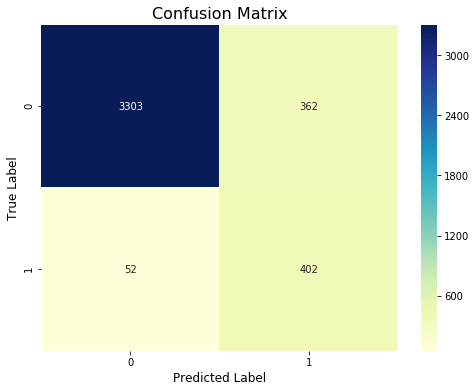

In [22]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_final, annot=True, cmap="YlGnBu", fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)

## ROC Curve

Text(0, 0.5, 'True Positive Rate')

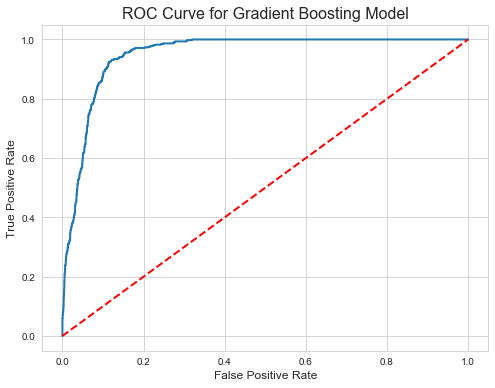

In [66]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_Test, yProb_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.title('ROC Curve for Gradient Boosting Model', fontsize=16)
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')  
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

## Importance of Features

Text(0, 0.5, 'Feature')

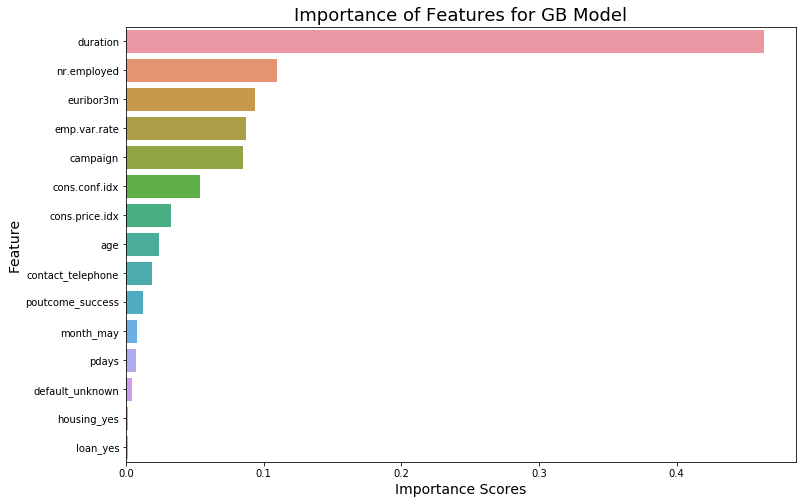

In [23]:
features = list(etc_X_Test.columns)
fi_df = pd.DataFrame(data=importance, index=features, columns=['Importance_Score'])
fi_df['Level'] = fi_df.Importance_Score.abs()
fi_df_sorted = fi_df.sort_values(by='Level', ascending=False)
fi_df_sorted.drop('Level', axis=1, inplace=True)

plt.figure(figsize=(12,8))
sns.barplot(np.array(fi_df_sorted.Importance_Score), np.array(fi_df_sorted.index.values))
plt.title('Importance of Features for GB Model', fontsize=18)
plt.xlabel('Importance Scores', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# STEP 5. Conclusion

### The goal of our project is to provide the best predictive model for Portuguese bank marketing campaign dataset. 
### 1. Four resampling techniques were implemented for the unbalanced data and we chose SMOTE method which gave the best F1-score. 
### 2. Four different feature selection methods were used to determine the relevent features and Extra Tree classifier gave the best F1-score with a reduced set of 15 features.
### 3. Eight predictive models were built and amongst these models, Gradient Boosting classifier was chosen as our final model which gave the highest F1 and ROC-AUC scores.
### 4. 5-fold Cross Validation was used for all the steps in our training process.
### 5. Hyperparameter tuning was performed on the Gradient Boosting to get the best parameters.
### 6. Finally, we assessed the performance of our final model with TEST set to see how it would perform on new data. Our final model has much better balanced sensitivities compared with results found in previous work [Elsalamony, 2014] and also has much higher value of ROC-AUC score (0.95) than ones found in [Moro et al., 2014].